# **4 Kernel Power on SVM and Regularized Logistic Regression (Ray)**

Generating a dataset with 100 samples and 5,000,000 features from the standard normal distribution.

In [1]:
import pickle
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime
from numpy.linalg import norm

In [2]:
def check_gradient(model, X, y, dimensionality, verbose=True):
    # This checks that the gradient implementation is correct
    w = np.random.rand(dimensionality)
    f, g = model.funObj(w, X, y)

    # Check the gradient
    estimated_gradient = approx_fprime(w,
                                       lambda w: model.funObj(w,X,y)[0],
                                       epsilon=1e-6)

    implemented_gradient = model.funObj(w, X, y)[1]

    if np.max(np.abs(estimated_gradient - implemented_gradient) > 1e-3):
        raise Exception('User and numerical derivatives differ:\n%s\n%s' %
             (estimated_gradient[:5], implemented_gradient[:5]))
    else:
        if verbose:
            print('User and numerical derivatives agree.')

In [3]:
def plotClassifier(model, X, y, ax):
    """plots the decision boundary of the model and the scatterpoints
       of the target values 'y'.

    Assumptions
    -----------
    y : it should contain two classes: '1' and '2'

    Parameters
    ----------
    model : the trained model which has the predict function

    X : the N by D feature array

    y : the N element vector corresponding to the target values

    """
    x1 = X[:, 0]
    x2 = X[:, 1]

    x1_min, x1_max = int(x1.min()) - 1, int(x1.max()) + 1
    x2_min, x2_max = int(x2.min()) - 1, int(x2.max()) + 1

    x1_line =  np.linspace(x1_min, x1_max, 200)
    x2_line =  np.linspace(x2_min, x2_max, 200)

    x1_mesh, x2_mesh = np.meshgrid(x1_line, x2_line)

    mesh_data = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]

    y_pred = model.predict(mesh_data)
    y_pred = np.reshape(y_pred, x1_mesh.shape)

    # plt.figure()
    ax.set_xlim([x1_mesh.min(), x1_mesh.max()])
    ax.set_ylim([x2_mesh.min(), x2_mesh.max()])

    ax.contourf(x1_mesh, x2_mesh, -y_pred.astype(int), # unsigned int causes problems with negative sign... o_O
                cmap=plt.cm.RdBu, alpha=0.6)


    y_vals = np.unique(y)
    ax.scatter(x1[y==y_vals[0]], x2[y==y_vals[0]], color="b", label="class %+d" % y_vals[0])
    ax.scatter(x1[y==y_vals[1]], x2[y==y_vals[1]], color="r", label="class %+d" % y_vals[1])
    ax.legend()

In [4]:
def findMin(funObj, w, maxEvals, *args, verbose=0):
    """
    Uses gradient descent to optimize the objective function

    This uses quadratic interpolation in its line search to
    determine the step size alpha
    """
    # Parameters of the Optimization
    optTol = 1e-2
    gamma = 1e-4

    # Evaluate the initial function value and gradient
    f, g = funObj(w,*args)
    funEvals = 1

    alpha = 1.
    while True:
        # Line-search using quadratic interpolation to 
        # find an acceptable value of alpha
        gg = g.T.dot(g)

        while True:
            w_new = w - alpha * g
            f_new, g_new = funObj(w_new, *args)

            funEvals += 1
            if f_new <= f - gamma * alpha*gg:
                break

            if verbose > 1:
                print("f_new: %.3f - f: %.3f - Backtracking..." % (f_new, f))

            # Update step size alpha
            alpha = (alpha**2) * gg/(2.*(f_new - f + alpha*gg))

        # Print progress
        if verbose > 0:
            print("%d - loss: %.3f" % (funEvals, f_new))

        # Update step-size for next iteration
        y = g_new - g
        alpha = -alpha*np.dot(y.T,g) / np.dot(y.T,y)

        # Safety guards
        if np.isnan(alpha) or alpha < 1e-10 or alpha > 1e10:
            alpha = 1.

        if verbose > 1:
            print("alpha: %.3f" % (alpha))

        # Update parameters/function/gradient
        w = w_new
        f = f_new
        g = g_new

        # Test termination conditions
        optCond = norm(g, float('inf'))

        if optCond < optTol:
            if verbose:
                print("Problem solved up to optimality tolerance %.3f" % optTol)
            break

        if funEvals >= maxEvals:
            if verbose:
                print("Reached maximum number of function evaluations %d" % maxEvals)
            break

    return w, f

In [5]:
def log_1_plus_exp_safe(x):
    out = np.log(1+np.exp(x))
    out[x > 100] = x[x>100]
    out[x < -100] = np.exp(x[x < -100])
    return out

In [6]:
def kernel_linear(X1, X2):
    return X1@X2.T

In [7]:
class kernelLogRegL2():
    def __init__(self, lammy=1.0, verbose=0, maxEvals=100, kernel_fun=kernel_linear, **kernel_args):
        self.verbose = verbose
        self.lammy = lammy
        self.maxEvals = maxEvals
        self.kernel_fun = kernel_fun
        self.kernel_args = kernel_args

    def funObj(self, u, K, y):
        yKu = y * (K@u)

        # Calculate the function value
        # f = np.sum(np.log(1. + np.exp(-yKu)))
        f = np.sum(log_1_plus_exp_safe(-yKu))

        # Add L2 regularization
        f += 0.5 * self.lammy * u.T@K@u

        # Calculate the gradient value
        res = - y / (1. + np.exp(yKu))
        g = (K.T@res) + self.lammy * K@u

        return f, g


    def fit(self, X, y):
        n, d = X.shape
        self.X = X

        K = self.kernel_fun(X,X, **self.kernel_args)

        check_gradient(self, K, y, n, verbose=self.verbose)
        self.u, f = findMin(self.funObj, np.zeros(n), self.maxEvals, K, y, verbose=self.verbose)

    def predict(self, Xtest):
        Ktest = self.kernel_fun(Xtest, self.X, **self.kernel_args)
        return np.sign(Ktest@self.u)

In [29]:
def kernel_RBF(X1, X2, sigma=0.5):
    # -||x1||^2     # -||x2||^2 + 2 * x1*x2.T
    return np.exp((- np.array([list(np.sum(X1 ** 2, axis=1))] * len(X2)).T
                   - np.array([list(np.sum(X2 ** 2, axis=1).T)] * len(X1))
                   + 2 * X1@X2.T) / sigma ** 2)

def kernel_poly(X1, X2, p=2):
    return (1 + X1@X2.T) ** p

Reading the data and split it into the train and test parts using random_state=2022

In [9]:
from sklearn.model_selection import train_test_split
data_raw = pd.read_csv('nonlineardata.csv')
data_train, data_test = train_test_split(data_raw, test_size=0.20, random_state=2022)
data_train, data_test = np.array(data_train), np.array(data_test)
X_train, y_train = data_train[:,:-1], data_train[:,-1]
X_test, y_test = data_test[:,:-1], data_test[:,-1]

**4.1**

Training a soft-margin SVM with linear kernel and C = 100. Plotting the decision boundary and reporting
training and testing error rate.

Training error 22.9%, test error 10.0%.

(comparing with sklearn linear kernel. Answers are the same)

Score for linear:
	Train: 0.7711598746081505;	Test: 0.9
Error rate for linear:
	Train: 0.2288401253918495;	Test: 0.09999999999999998
 
0.2288401253918495 0.09999999999999998


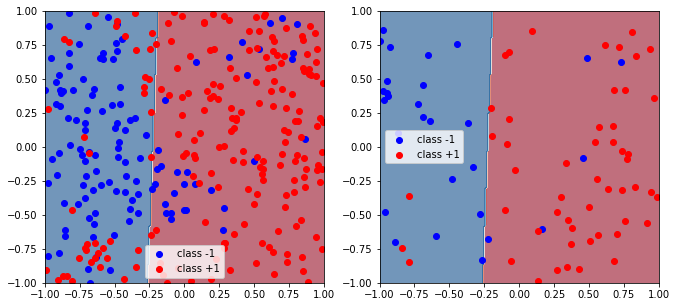

In [10]:
from sklearn.svm import SVC
SVC_linear = SVC(kernel=kernel_linear, C=100)
SVC_linear.fit(X_train, y_train)
print(f'Score for linear:\n'
      f'\tTrain: {SVC_linear.score(X_train, y_train)};'
      f'\tTest: {SVC_linear.score(X_test, y_test)}\n'
      f'Error rate for linear:\n'
      f'\tTrain: {1 - SVC_linear.score(X_train, y_train)};'
      f'\tTest: {1 - SVC_linear.score(X_test, y_test)}\n ')
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
plotClassifier(SVC_linear, X_train, y_train, ax=ax1)
plotClassifier(SVC_linear, X_test, y_test, ax=ax2)

SVC_linear_skl = SVC(kernel='linear', C=100)
SVC_linear_skl.fit(X_train, y_train)
print(1 - SVC_linear_skl.score(X_train, y_train), 1 - SVC_linear_skl.score(X_test, y_test))

**4.2**

Training a soft-margin soft-margin SVM with polynomial kernel. Plotting the decision boundary and reporting
training and testing error rate.

Training error 17.6%, test error 13.7%.

(comparing with sklearn linear kernel. For some reason I didn't make it work correctly for skleanr 'poly',
even thou I was trying to change different parameters.)

Score for linear:
	Train: 0.8244514106583072;	Test: 0.8625
Error rate for linear:
	Train: 0.17554858934169282;	Test: 0.13749999999999996
 
0.3824451410658307 0.35


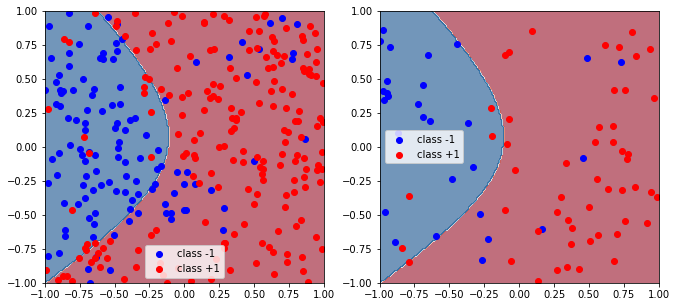

In [30]:
SVC_poly = SVC(kernel=kernel_poly, C=100)
SVC_poly.fit(X_train, y_train)
print(f'Score for linear:\n'
      f'\tTrain: {SVC_poly.score(X_train, y_train)};'
      f'\tTest: {SVC_poly.score(X_test, y_test)}\n'
      f'Error rate for linear:\n'
      f'\tTrain: {1 - SVC_poly.score(X_train, y_train)};'
      f'\tTest: {1 - SVC_poly.score(X_test, y_test)}\n ')
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
plotClassifier(SVC_poly, X_train, y_train, ax=ax1)
plotClassifier(SVC_poly, X_test, y_test, ax=ax2)

SVC_poly_skl = SVC(kernel='poly', C=100, degree=2)
SVC_poly_skl.fit(X_train, y_train)
print(1 - SVC_poly_skl.score(X_train, y_train), 1 - SVC_poly_skl.score(X_test, y_test))
# _, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
# plotClassifier(SVC_poly_skl, X_train, y_train, ax=ax1)
# plotClassifier(SVC_poly_skl, X_test, y_test, ax=ax2)

**4.3**

Training a soft-margin soft-margin SVM with RBF kernel. Plotting the decision boundary and reporting
training and testing error rate.

(My own implementation of RBF kernel)

Training error 10.3%, test error 17.5%.

(comparing with sklearn rbf kernel. Answers are the same)

Score for linear:
	Train: 0.896551724137931;	Test: 0.825
Error rate for linear:
	Train: 0.10344827586206895;	Test: 0.17500000000000004
 
0.10344827586206895 0.17500000000000004


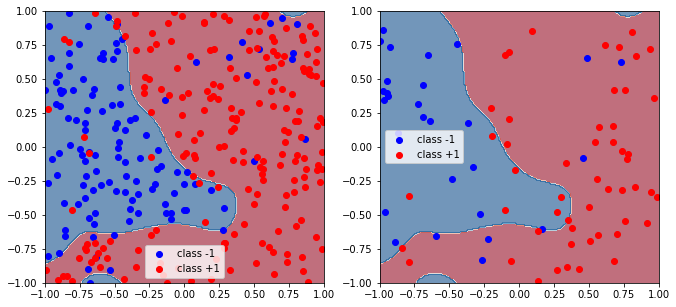

In [12]:
SVC_linear = SVC(kernel=kernel_RBF, C=100)
SVC_linear.fit(X_train, y_train)
print(f'Score for linear:\n'
      f'\tTrain: {SVC_linear.score(X_train, y_train)};'
      f'\tTest: {SVC_linear.score(X_test, y_test)}\n'
      f'Error rate for linear:\n'
      f'\tTrain: {1 - SVC_linear.score(X_train, y_train)};'
      f'\tTest: {1 - SVC_linear.score(X_test, y_test)}\n ')
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
plotClassifier(SVC_linear, X_train, y_train, ax=ax1)
plotClassifier(SVC_linear, X_test, y_test, ax=ax2)

SVC_poly_skl = SVC(kernel='rbf', C=100, gamma=1 / 0.5 ** 2)
SVC_poly_skl.fit(X_train, y_train)
print(1 - SVC_poly_skl.score(X_train, y_train), 1 - SVC_poly_skl.score(X_test, y_test))

Comparing my implementation of RBF kernel with sklearn one. Looks the same. Good sign

Score for linear:
	Train: 0.896551724137931;	Test: 0.825
Error rate for linear:
	Train: 0.10344827586206895;	Test: 0.17500000000000004
 


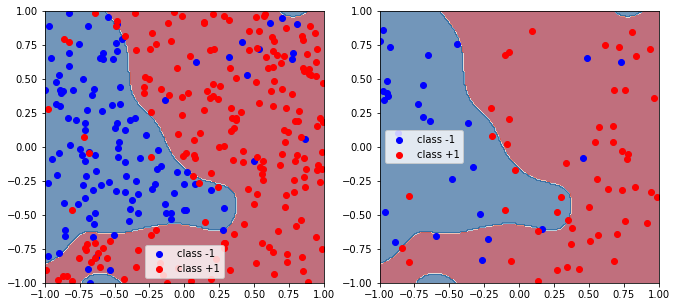

In [13]:
SVC_linear = SVC(kernel='rbf', C=100, gamma=1/0.5**2)
SVC_linear.fit(X_train, y_train)
print(f'Score for linear:\n'
      f'\tTrain: {SVC_linear.score(X_train, y_train)};'
      f'\tTest: {SVC_linear.score(X_test, y_test)}\n'
      f'Error rate for linear:\n'
      f'\tTrain: {1 - SVC_linear.score(X_train, y_train)};'
      f'\tTest: {1 - SVC_linear.score(X_test, y_test)}\n ')
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
plotClassifier(SVC_linear, X_train, y_train, ax=ax1)
plotClassifier(SVC_linear, X_test, y_test, ax=ax2)

Plotting the training and test error rates vs $\gamma$.

We can see, that the training error is going to zero because we strongly overfitting the data and thus,
the test error is increasing. There is a range of optimum values where the test error is small
(~10^-3 up to 10^0).

We can clearly see why it is happening on the next plots with boundaries. With larger $\gamma$ we starting
to place all the points from one category in their own "small bags" (gaussians), saying that everything else
has another label, - strongly overfitting the data.

Small $\gamma$ values corresponds to high bias, we are oversimplifying the data, placing huge gaussians
on top of the points.
with high $\gamma$ values we getting high variance - overfitting the data.

(Tried with both mine implementation and
rbf implementation by sklearn. Results are the same.)

[0.25705329153605017, 0.22570532915360497, 0.20376175548589337, 0.15987460815047017, 0.11285266457680254, 0.07210031347962387, 0.009404388714733591, 0.0] [0.17500000000000004, 0.11250000000000004, 0.13749999999999996, 0.13749999999999996, 0.13749999999999996, 0.21250000000000002, 0.22499999999999998, 0.32499999999999996]


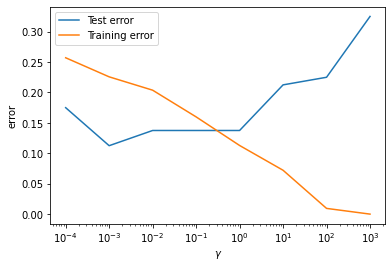

In [32]:
errors_train = []
errors_test = []
gammas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for gamma in gammas:
    def kernel_RBF_helper(X1, X2):
        sigma = np.sqrt(1 / gamma)
        return kernel_RBF(X1, X2, sigma)
    SVC_linear = SVC(kernel=kernel_RBF_helper, C=100)
    # SVC_linear = SVC(kernel='rbf', C=100, gamma=gamma)
    SVC_linear.fit(X_train, y_train)
    errors_train.append(1 - SVC_linear.score(X_train, y_train))
    errors_test.append(1 - SVC_linear.score(X_test, y_test))
print(errors_train, errors_test)
plt.plot(gammas, errors_test, label='Test error')
plt.plot(gammas, errors_train, label='Training error')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel('error')
plt.show()

Score for linear:
	Train: 0.7429467084639498;	Test: 0.825
Error rate for linear:
	Train: 0.25705329153605017;	Test: 0.17500000000000004
 
Score for linear:
	Train: 0.774294670846395;	Test: 0.8875
Error rate for linear:
	Train: 0.22570532915360497;	Test: 0.11250000000000004
 
Score for linear:
	Train: 0.7962382445141066;	Test: 0.8625
Error rate for linear:
	Train: 0.20376175548589337;	Test: 0.13749999999999996
 
Score for linear:
	Train: 0.8401253918495298;	Test: 0.8625
Error rate for linear:
	Train: 0.15987460815047017;	Test: 0.13749999999999996
 
Score for linear:
	Train: 0.8871473354231975;	Test: 0.8625
Error rate for linear:
	Train: 0.11285266457680254;	Test: 0.13749999999999996
 
Score for linear:
	Train: 0.9278996865203761;	Test: 0.7875
Error rate for linear:
	Train: 0.07210031347962387;	Test: 0.21250000000000002
 
Score for linear:
	Train: 0.9905956112852664;	Test: 0.775
Error rate for linear:
	Train: 0.009404388714733591;	Test: 0.22499999999999998
 
Score for linear:
	Train: 1.0

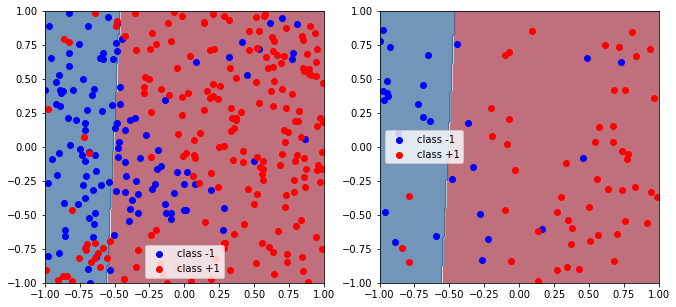

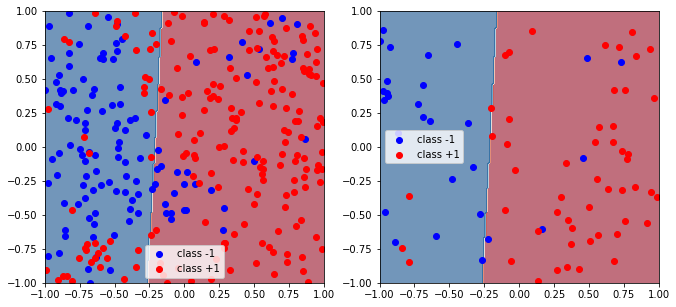

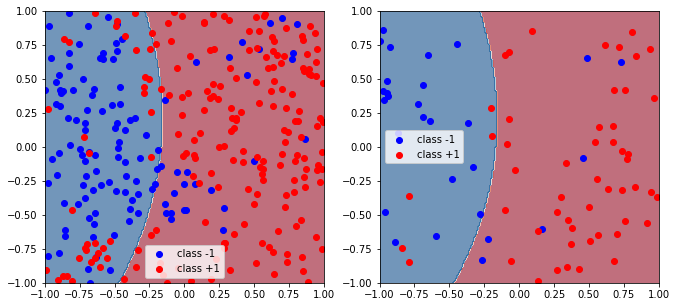

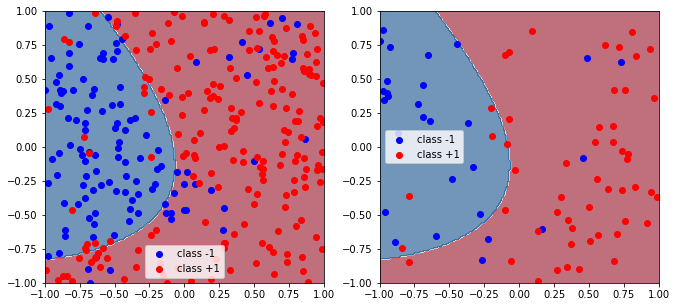

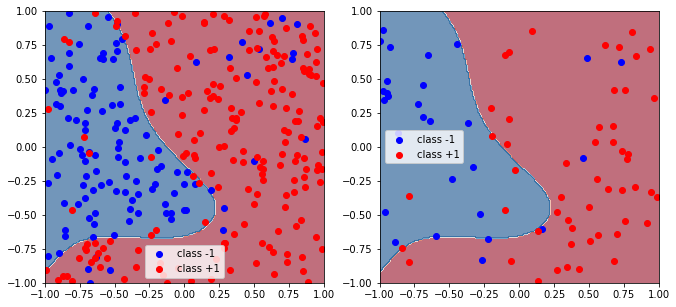

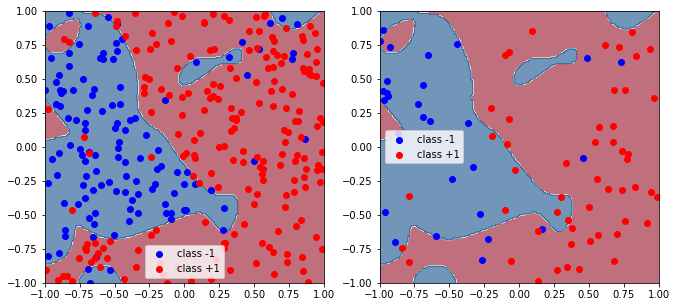

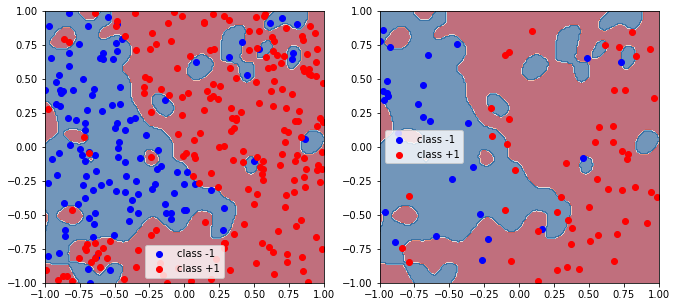

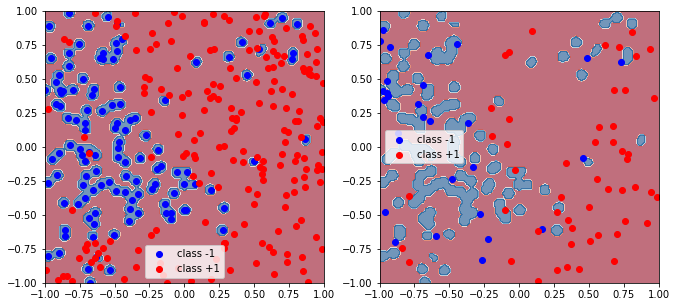

In [15]:
for gamma in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    sigma = np.sqrt(1 / gamma)
    def kernel_RBF_helper(X1, X2):
        global sigma
        return kernel_RBF(X1, X2, sigma)
    SVC_linear = SVC(kernel=kernel_RBF_helper, C=100)
    SVC_linear.fit(X_train, y_train)
    print(f'Score for linear:\n'
          f'\tTrain: {SVC_linear.score(X_train, y_train)};'
          f'\tTest: {SVC_linear.score(X_test, y_test)}\n'
          f'Error rate for linear:\n'
          f'\tTrain: {1 - SVC_linear.score(X_train, y_train)};'
          f'\tTest: {1 - SVC_linear.score(X_test, y_test)}\n ')
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
    plotClassifier(SVC_linear, X_train, y_train, ax=ax1)
    plotClassifier(SVC_linear, X_test, y_test, ax=ax2)
    plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression